# Imports

In [110]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from evalstudent import metrics
from evalstudent import utils
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EDA (Exploratory Data Analysis)

## Loading data

In [20]:
!cd ../..;tree -L 2

.
├── MANIFEST.in
├── Makefile
├── README.md
├── evalstudent
│   ├── __init__.py
│   ├── __pycache__
│   ├── data
│   ├── metrics.py
│   └── utils.py
├── evalstudent.egg-info
│   ├── PKG-INFO
│   ├── SOURCES.txt
│   ├── dependency_links.txt
│   ├── not-zip-safe
│   └── top_level.txt
├── notebooks
│   ├── valentin
│   └── yoann
├── raw_data
│   ├── sample_submission.csv
│   ├── test
│   ├── train
│   └── train.csv
├── requirements.txt
├── scripts
│   └── evalstudent-run
├── setup.py
└── tests
    └── __init__.py

12 directories, 17 files


In [6]:
train_df = pd.read_csv("../../raw_data/train.csv", dtype = {"discourse_id": int, "discourse_start": int, "discourse_end": int})

In [7]:
train_df.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


## Displaying classes

In [21]:
utils.display_classes("423A1CA112E2", train_df)

## Class balance

In [16]:
(train_df.groupby("discourse_type").id.count()/train_df.shape[0]*100).map(round)

discourse_type
Claim                   35
Concluding Statement     9
Counterclaim             4
Evidence                32
Lead                     6
Position                11
Rebuttal                 3
Name: id, dtype: int64

## Lead position in essays

In [154]:
# Lead start character
train_df[train_df["discourse_type"] == "Lead"]["discourse_start"].mean()

6.2266523374529825

In [156]:
# Lead end character
train_df[train_df["discourse_type"] == "Lead"]["discourse_end"].mean()

298.78355722729714

## Essays length

In [157]:
essay_ids = train_df.id.unique()
essay_len = []
for essay_id in essay_ids:
    essay_text = open(f"../../raw_data/train/{essay_id}.txt").read()
    essay_len.append(len(essay_text))

np.mean(essay_len)

2364.0979864050278

<AxesSubplot:>

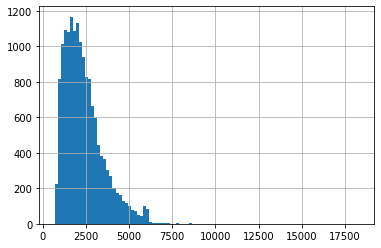

In [158]:
pd.Series(essay_len).hist(bins=100)

## Topics

Here are the topics we're looking for: https://www.kaggle.com/c/feedback-prize-2021/discussion/301481

Working on a subset of the data:

In [57]:
ids = train_df.id.values.copy()
np.random.shuffle(ids) # We need to shuffle because the data is actually sorted by topics
ids_subset = ids[0:150]

sub_data = [open(f'../../raw_data/train/{essay_id}.txt').read() for essay_id in ids_subset]

In [60]:
vect = CountVectorizer()
X = vect.fit_transform(sub_data)

In [61]:
model = LatentDirichletAllocation()
model = LatentDirichletAllocation(n_components=15)
model.fit(X)

def print_topics(model, vect):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vect.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])

print_topics(model,vect)

Topic 0:
[('the', 172.82254500117247), ('that', 80.52770479122563), ('face', 80.17858026214711), ('to', 72.7622234827799), ('it', 71.89678834929373), ('in', 65.34423092672304), ('of', 63.38028921658119), ('they', 50.219396460404965), ('and', 48.393616639433084), ('is', 47.09359500962151)]
Topic 1:
[('to', 613.091957932786), ('the', 501.07731620732557), ('and', 389.82072626593487), ('that', 322.018139933217), ('of', 255.37354591792155), ('in', 249.06198441339708), ('can', 200.4700481663499), ('they', 196.992662287954), ('have', 180.94145395796957), ('is', 173.85007426666556)]
Topic 2:
[('plurality', 0.06666666666687518), ('pedigree', 0.06666666666687518), ('continuing', 0.06666666666677169), ('intimidating', 0.06666666666675286), ('handedly', 0.0666666666667507), ('thirds', 0.0666666666667507), ('machine', 0.06666666666674344), ('forth', 0.0666666666667403), ('therefor', 0.0666666666667403), ('vanquished', 0.0666666666667403)]
Topic 3:
[('the', 1012.74692348668), ('of', 301.474849907974